In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras as kr
import random 
import model_prep_withFE
import model_prep_withoutFE
import operator
import lightgbm as lgb
import statsmodels.api as sm
import catboost as cb
import xgboost as xgb

from model_prep_withFE import prepare_data, get_features, get_bounds, get_interval_accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from catboost import CatBoostRegressor, Pool

# Based on dataset used, use corresponding model_prep scripts to 
# load in respective cleaned dataset using one of the load functions below

# Load in pre-split data for data including feature engineering
X_train, X_test, y_train, y_test = prepare_data()
features = get_features()
train_bounds_5 = get_bounds(y_train, 5)
train_bounds_10 = get_bounds(y_train, 10)
test_bounds_5 = get_bounds(y_test, 5)
test_bounds_10 = get_bounds(y_test, 10)

# Load in pre-split data for original data excluding feature engineering
# X_train, X_test, y_train, y_test = model_prep_withoutFE.prepare_data()
# features = base_preprocessor.get_features()
# train_bounds_5 = get_bounds(y_train, 5)
# train_bounds_10 = get_bounds(y_train, 10)
# test_bounds_5 = get_bounds(y_test, 5)
# test_bounds_10 = get_bounds(y_test, 10)

Using TensorFlow backend.


Train data(range):
2019-04-11 21:50:04
2019-08-22 19:06:11
Test data(range):
2019-04-11 21:50:04
2019-08-22 19:04:20


### Linear Regression

In [4]:
# Linear Regression model (without regularization)
lm = LinearRegression()
lm.fit(X_train, y_train)

# Compute predictions
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

# Compute metrics
MSE = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Train Scores:")
print(MSE)
print(r2)

MSE = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Test Scores:")
print(MSE)
print(r2)

# Display coefficients 
coef_df = pd.DataFrame(lm.coef_[0], features, columns=['Coefficient'])
coef_df

Train Scores:
103.19213529708983
0.8419558545799847
Test Scores:
99.7881962740039
0.8460843324784137


,Coefficient
travel_mins,-3.905887e+01
originpop,8.025352e+11
destinationpop,-3.381733e+11
days_to_holiday,1.636527e+00
days_from_holiday,-6.920711e-01
distance,3.438328e+13
month,-2.927974e+00
date,1.014568e+00
hour,-2.263220e-02
minute,-3.172042e+00


In [7]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(get_interval_accuracy_score(train_bounds_5, y_pred_train))
print(get_interval_accuracy_score(test_bounds_5, y_pred_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(train_bounds_10, y_pred_train))
print(get_interval_accuracy_score(test_bounds_10, y_pred_test))

5% +/- limit:
0.302
0.293
10% +/- limit:
0.535175
0.53165


### Random Forest Regression

In [8]:
y_train = list(np.array(y_train).flatten())
y_test = list(np.array(y_test).flatten())

In [ ]:
# Perform cross validation to find best hyper parameters for random forest models
rfr = RandomForestRegressor()
parameters = {
            "n_estimators" : [50, 75, 150, 250, 300, 400],
            "max_depth": [None, 5, 8, 12, 15],
            "max_features": ['auto','sqrt']
            }

ran = RandomizedSearchCV(estimator=rfr, param_distributions=parameters, cv=5, n_jobs=-1, n_iter=10, random_state=0, verbose=2)
ran.fit(X_train, y_train)

# View best parameters to use in final model
ran.best_params_

In [9]:
# Train Random Forest model using best hyper parameters 
rf_150 = RandomForestRegressor(n_estimators=150, max_depth=None)
rf_150.fit(X_train, y_train)

# Compute predictions 
y_pred_train = rf_150.predict(X_train)
y_pred_test = rf_150.predict(X_test)

# Compute metrics
MSE = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Train Scores:")
print(MSE)
print(r2)

MSE = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Test Scores:")
print(MSE)
print(r2)

Train Scores:
2.4478998409971404
0.9962429381109045
Test Scores:
19.143323956317957
0.9707198913292429


In [10]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(get_interval_accuracy_score(train_bounds_5, y_pred_train))
print(get_interval_accuracy_score(test_bounds_5, y_pred_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(train_bounds_10, y_pred_train))
print(get_interval_accuracy_score(test_bounds_10, y_pred_test))

5% +/- limit:
0.9270625
0.76625
10% +/- limit:
0.9814
0.8911


In [ ]:
y_pred_train = rf_150.predict(X_train)
y_pred_test = rf_150.predict(X_test)
print(rf_150.score(X_test, y_test))
print(mean_squared_error(y_test, rf_150.predict(X_test)))
print("5% +/- limit:")
print(get_interval_accuracy_score(train_bounds_5, y_pred_train))
print(get_interval_accuracy_score(test_bounds_5, y_pred_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(train_bounds_10, y_pred_train))
print(get_interval_accuracy_score(test_bounds_10, y_pred_test))

### Gradient Boosting

#### GradientBoostingRegressor

In [11]:
model = GradientBoostingRegressor(n_estimators=500, max_depth=8, loss='ls', min_samples_split=2, learning_rate=0.01)

In [12]:
# Fit model 
model.fit(X_train, y_train)

# Compute MSE and R2 scores on testing
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.9393857604651752
39.62956684446618


In [13]:
test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

Text(0, 0.5, 'Deviance')

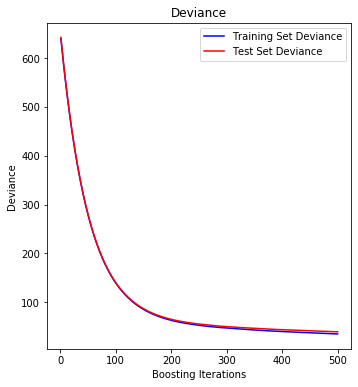

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(500) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Text(0.5, 1.0, 'Gradient Boost Actual vs. Predicted Values')

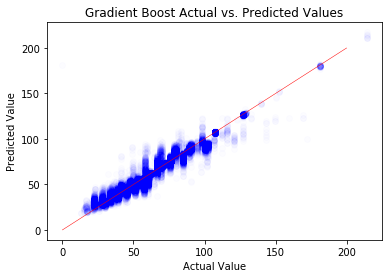

In [17]:
y_pred_train_gb = model.predict(X_train)
y_pred_test_gb = model.predict(X_test)
plt.plot(y_test, y_preds_test_gb, 'bo', alpha = 0.01)
plt.plot([0, 200], [0, 200], color = 'red', linewidth = 0.5)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Gradient Boost Actual vs. Predicted Values")

In [18]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(get_interval_accuracy_score(train_bounds_5, y_pred_train_gb))
print(get_interval_accuracy_score(test_bounds_5, y_pred_test_gb))
print("10% +/- limit:")
print(get_interval_accuracy_score(train_bounds_10, y_pred_train_gb))
print(get_interval_accuracy_score(test_bounds_10, y_pred_test_gb))

5% +/- limit:
0.53325
0.52765
10% +/- limit:
0.7411
0.7302


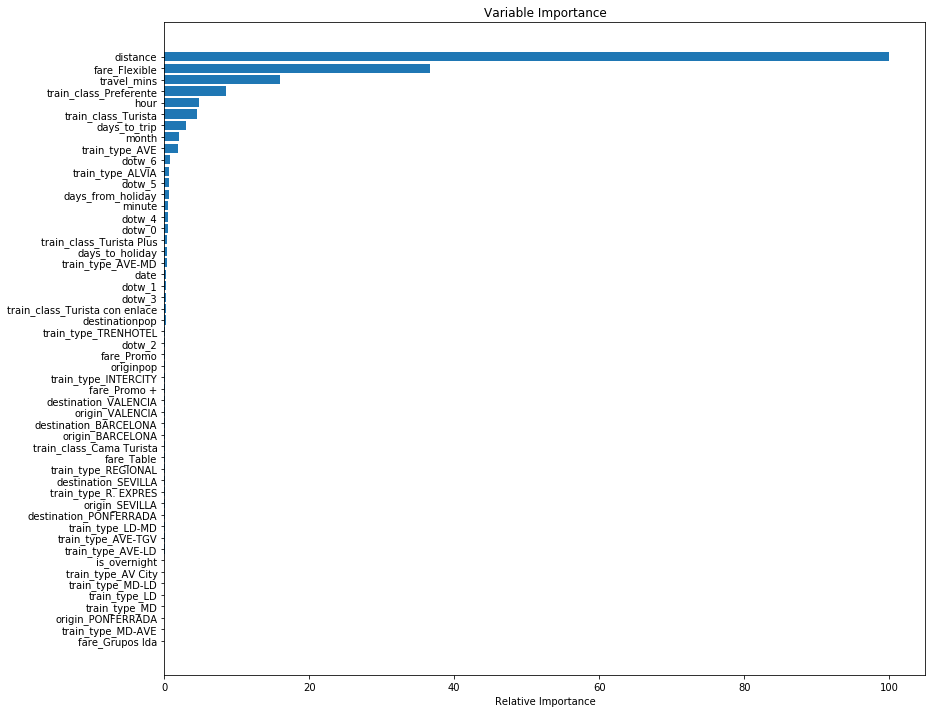

In [19]:
# Calculate variable importance for mode
indices = np.array(list(range(len(features))))
features = np.array(features)[indices.astype(int)]
feature_importance = model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### XGBoost

In [5]:
xg_train = pd.DataFrame(X_train)
xg_test = pd.DataFrame(X_test)
xg_train.columns = features
xg_test.columns = features

In [22]:
# Perform cross validation to find best hyperparameters for model
cv_params = {'max_depth': [2, 4, 6, 8], 'eta': [1, 0.5],'lambda': [1, 3, 5], 'learning_rate' : [0.2, 0.1, 0.05]}
ind_params = {'objective': 'reg:squarederror', 'seed': 0}
optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, cv=3, n_jobs=-1)

In [ ]:
# Fit cross validated model 
gs_XGBM = optimized_GBM.fit(xg_train, y_train)

In [32]:
# Extract best parameters to use in final model
bst = optimized_GBM.best_estimator_

In [7]:
# Train and fit the model using the best estimators from above
model = xgb.XGBRegressor(n_estimators=100, eta=0.5, max_depth=8)
model.fit(xg_train, y_train)

[21:45:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [15]:
# Compute predictions
y_pred_train = model.predict(xg_train)
y_pred_test = model.predict(xg_test)

# Compute metrics on testing data
print(r2_score(y_test, y_pred_test))
print(mean_squared_error(y_test, y_pred_test))

# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(get_interval_accuracy_score(train_bounds_5, y_pred_train))
print(get_interval_accuracy_score(test_bounds_5, y_pred_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(train_bounds_10, y_pred_train))
print(get_interval_accuracy_score(test_bounds_10, y_pred_test))

0.9509429912003211
31.805146945364353
5% +/- limit:
0.5764625
0.56525
10% +/- limit:
0.7865125
0.77275


#### CatBoost

In [ ]:
# Perform cross validation to identify best hyper paremeters for model
params = {'iterations': [300, 500, 1000],
        'learning_rate': [0.2, 0.1, 0.01],
        'depth': [6, 8, 10],
        'l2_leaf_reg': [1, 3, 5]}
cbm = CatBoostRegressor()

gs_result = cbm.grid_search(params, X=X_train, y=y_train, plot=True)

In [11]:
# Use best hyper paremeters for model from CV performed above
cbe = cb.CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=10, l2_leaf_reg=1)

In [12]:
# Fit model
cbe.fit(X_train, y_train)
cbe_y_preds_test = cbe.predict(X_test)

0:	learn: 21.2751274	total: 156ms	remaining: 2m 35s
1:	learn: 17.9366140	total: 229ms	remaining: 1m 54s
2:	learn: 15.3329286	total: 300ms	remaining: 1m 39s
3:	learn: 13.3853309	total: 360ms	remaining: 1m 29s
4:	learn: 11.8511880	total: 394ms	remaining: 1m 18s
5:	learn: 10.7125012	total: 429ms	remaining: 1m 11s
6:	learn: 9.8690070	total: 466ms	remaining: 1m 6s
7:	learn: 9.2383496	total: 503ms	remaining: 1m 2s
8:	learn: 8.8100895	total: 545ms	remaining: 1m
9:	learn: 8.4751955	total: 587ms	remaining: 58.1s
10:	learn: 8.2098588	total: 623ms	remaining: 56.1s
11:	learn: 7.9995152	total: 662ms	remaining: 54.5s
12:	learn: 7.8487637	total: 700ms	remaining: 53.2s
13:	learn: 7.7402379	total: 738ms	remaining: 52s
14:	learn: 7.6092901	total: 776ms	remaining: 50.9s
15:	learn: 7.4870980	total: 812ms	remaining: 49.9s
16:	learn: 7.3598405	total: 860ms	remaining: 49.8s
17:	learn: 7.2805506	total: 900ms	remaining: 49.1s
18:	learn: 7.2076633	total: 940ms	remaining: 48.5s
19:	learn: 7.1339968	total: 978ms	

161:	learn: 4.5397354	total: 6.68s	remaining: 34.5s
162:	learn: 4.5286207	total: 6.71s	remaining: 34.4s
163:	learn: 4.5210112	total: 6.75s	remaining: 34.4s
164:	learn: 4.5176321	total: 6.78s	remaining: 34.3s
165:	learn: 4.5058083	total: 6.82s	remaining: 34.3s
166:	learn: 4.5020854	total: 6.85s	remaining: 34.2s
167:	learn: 4.4859942	total: 6.88s	remaining: 34.1s
168:	learn: 4.4762703	total: 6.91s	remaining: 34s
169:	learn: 4.4696848	total: 6.95s	remaining: 34s
170:	learn: 4.4587080	total: 6.99s	remaining: 33.9s
171:	learn: 4.4506330	total: 7.03s	remaining: 33.8s
172:	learn: 4.4457478	total: 7.07s	remaining: 33.8s
173:	learn: 4.4364762	total: 7.11s	remaining: 33.8s
174:	learn: 4.4309559	total: 7.15s	remaining: 33.7s
175:	learn: 4.4260991	total: 7.19s	remaining: 33.7s
176:	learn: 4.4215576	total: 7.23s	remaining: 33.6s
177:	learn: 4.4117536	total: 7.27s	remaining: 33.6s
178:	learn: 4.4098120	total: 7.31s	remaining: 33.5s
179:	learn: 4.4015376	total: 7.35s	remaining: 33.5s
180:	learn: 4.39

324:	learn: 3.6019595	total: 13.2s	remaining: 27.5s
325:	learn: 3.5991582	total: 13.3s	remaining: 27.4s
326:	learn: 3.5948939	total: 13.3s	remaining: 27.4s
327:	learn: 3.5915402	total: 13.3s	remaining: 27.3s
328:	learn: 3.5882242	total: 13.4s	remaining: 27.3s
329:	learn: 3.5857423	total: 13.4s	remaining: 27.2s
330:	learn: 3.5811032	total: 13.5s	remaining: 27.2s
331:	learn: 3.5775325	total: 13.5s	remaining: 27.2s
332:	learn: 3.5739382	total: 13.6s	remaining: 27.1s
333:	learn: 3.5702883	total: 13.6s	remaining: 27.1s
334:	learn: 3.5668499	total: 13.6s	remaining: 27.1s
335:	learn: 3.5621700	total: 13.7s	remaining: 27s
336:	learn: 3.5585082	total: 13.7s	remaining: 27s
337:	learn: 3.5549235	total: 13.7s	remaining: 26.9s
338:	learn: 3.5502067	total: 13.8s	remaining: 26.9s
339:	learn: 3.5474816	total: 13.8s	remaining: 26.8s
340:	learn: 3.5420553	total: 13.9s	remaining: 26.8s
341:	learn: 3.5359748	total: 13.9s	remaining: 26.7s
342:	learn: 3.5314639	total: 13.9s	remaining: 26.7s
343:	learn: 3.52

486:	learn: 3.1090088	total: 20s	remaining: 21s
487:	learn: 3.1048574	total: 20s	remaining: 21s
488:	learn: 3.1024594	total: 20.1s	remaining: 21s
489:	learn: 3.0999813	total: 20.1s	remaining: 20.9s
490:	learn: 3.0981283	total: 20.1s	remaining: 20.9s
491:	learn: 3.0967380	total: 20.2s	remaining: 20.8s
492:	learn: 3.0951368	total: 20.2s	remaining: 20.8s
493:	learn: 3.0933884	total: 20.3s	remaining: 20.7s
494:	learn: 3.0898503	total: 20.3s	remaining: 20.7s
495:	learn: 3.0884098	total: 20.3s	remaining: 20.7s
496:	learn: 3.0857473	total: 20.4s	remaining: 20.6s
497:	learn: 3.0839058	total: 20.4s	remaining: 20.6s
498:	learn: 3.0815647	total: 20.5s	remaining: 20.6s
499:	learn: 3.0804396	total: 20.5s	remaining: 20.5s
500:	learn: 3.0756086	total: 20.5s	remaining: 20.5s
501:	learn: 3.0708333	total: 20.6s	remaining: 20.4s
502:	learn: 3.0676974	total: 20.6s	remaining: 20.4s
503:	learn: 3.0662734	total: 20.7s	remaining: 20.3s
504:	learn: 3.0644751	total: 20.7s	remaining: 20.3s
505:	learn: 3.0614867	

645:	learn: 2.7813171	total: 26.5s	remaining: 14.5s
646:	learn: 2.7805314	total: 26.5s	remaining: 14.5s
647:	learn: 2.7767885	total: 26.5s	remaining: 14.4s
648:	learn: 2.7746326	total: 26.6s	remaining: 14.4s
649:	learn: 2.7733812	total: 26.6s	remaining: 14.3s
650:	learn: 2.7709858	total: 26.7s	remaining: 14.3s
651:	learn: 2.7681631	total: 26.7s	remaining: 14.3s
652:	learn: 2.7666506	total: 26.7s	remaining: 14.2s
653:	learn: 2.7647076	total: 26.8s	remaining: 14.2s
654:	learn: 2.7627011	total: 26.8s	remaining: 14.1s
655:	learn: 2.7597599	total: 26.9s	remaining: 14.1s
656:	learn: 2.7583190	total: 26.9s	remaining: 14s
657:	learn: 2.7566551	total: 26.9s	remaining: 14s
658:	learn: 2.7553024	total: 27s	remaining: 14s
659:	learn: 2.7531629	total: 27s	remaining: 13.9s
660:	learn: 2.7506396	total: 27.1s	remaining: 13.9s
661:	learn: 2.7479848	total: 27.1s	remaining: 13.8s
662:	learn: 2.7473040	total: 27.2s	remaining: 13.8s
663:	learn: 2.7458170	total: 27.2s	remaining: 13.8s
664:	learn: 2.7446154	

807:	learn: 2.5147739	total: 33.1s	remaining: 7.85s
808:	learn: 2.5128561	total: 33.1s	remaining: 7.81s
809:	learn: 2.5117653	total: 33.1s	remaining: 7.77s
810:	learn: 2.5091952	total: 33.2s	remaining: 7.73s
811:	learn: 2.5086712	total: 33.2s	remaining: 7.69s
812:	learn: 2.5078330	total: 33.3s	remaining: 7.65s
813:	learn: 2.5071783	total: 33.3s	remaining: 7.61s
814:	learn: 2.5052970	total: 33.3s	remaining: 7.57s
815:	learn: 2.5040308	total: 33.4s	remaining: 7.53s
816:	learn: 2.5030528	total: 33.4s	remaining: 7.48s
817:	learn: 2.5016236	total: 33.5s	remaining: 7.44s
818:	learn: 2.5004312	total: 33.5s	remaining: 7.4s
819:	learn: 2.4997133	total: 33.5s	remaining: 7.36s
820:	learn: 2.4978888	total: 33.6s	remaining: 7.32s
821:	learn: 2.4967986	total: 33.6s	remaining: 7.28s
822:	learn: 2.4961286	total: 33.6s	remaining: 7.24s
823:	learn: 2.4935194	total: 33.7s	remaining: 7.19s
824:	learn: 2.4928550	total: 33.7s	remaining: 7.15s
825:	learn: 2.4893986	total: 33.8s	remaining: 7.11s
826:	learn: 2

968:	learn: 2.2985023	total: 39.4s	remaining: 1.26s
969:	learn: 2.2975902	total: 39.5s	remaining: 1.22s
970:	learn: 2.2964090	total: 39.5s	remaining: 1.18s
971:	learn: 2.2955526	total: 39.5s	remaining: 1.14s
972:	learn: 2.2946788	total: 39.6s	remaining: 1.1s
973:	learn: 2.2941322	total: 39.6s	remaining: 1.06s
974:	learn: 2.2927695	total: 39.7s	remaining: 1.02s
975:	learn: 2.2911078	total: 39.7s	remaining: 976ms
976:	learn: 2.2900678	total: 39.7s	remaining: 935ms
977:	learn: 2.2893570	total: 39.8s	remaining: 895ms
978:	learn: 2.2880897	total: 39.8s	remaining: 854ms
979:	learn: 2.2864408	total: 39.9s	remaining: 813ms
980:	learn: 2.2855423	total: 39.9s	remaining: 773ms
981:	learn: 2.2843702	total: 39.9s	remaining: 732ms
982:	learn: 2.2834697	total: 40s	remaining: 691ms
983:	learn: 2.2829985	total: 40s	remaining: 651ms
984:	learn: 2.2826157	total: 40s	remaining: 610ms
985:	learn: 2.2812459	total: 40.1s	remaining: 569ms
986:	learn: 2.2802078	total: 40.1s	remaining: 529ms
987:	learn: 2.27917

In [16]:
# Compute R2, MSE, and accuracy scores
print(r2_score(y_test, cbe_y_preds_test))
print(mean_squared_error(y_test, cbe_y_preds_test))

# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(get_interval_accuracy_score(test_bounds_5, cbe_y_preds_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(test_bounds_10, cbe_y_preds_test))

0.9725961817347567
17.76672667404516
5% +/- limit:
0.70255
10% +/- limit:
0.8758


### Neural Networks

In [18]:
# Flatten target variable to use in NN models
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Define functions for NN models, running models, etc
def base_model():
    model = Sequential()
    model.add(Dense(10, input_dim = 52, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear'))
    adam = Adam()
    # Compile
    model.compile(loss = 'mean_squared_error', optimizer=adam, metrics =['mean_squared_error'])
    return model

def run_network(xtrain, xtest, ytrain, ytest, model, epochs, batch):
    model.fit(xtrain, ytrain, nb_epoch = epochs, batch_size = batch,
              validation_data = (xtest, ytest),verbose = 2)
    return model

# Change the number of layers but hold the number of hidden neurons constant
def change_layers_neurons(numlayers, numneurons):
    model = Sequential()
    model.add(Dense(numneurons, input_dim = 52, kernel_initializer = 'normal', activation = 'relu'))
    for x in range(1- numlayers):
        model.add(Dense(numneurons, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear'))
    adam = Adam()
    model.compile(loss = 'mean_squared_error', optimizer=adam, metrics =['mean_squared_error'])
    return model

basemodel = base_model()
basemodel.summary()

# Run Network for Base Model
run_network(X_train, X_test, y_train, y_test, basemodel, 10,20)

# Create more networks hold number of neurons/layer constant
 
# 5 layers
model1 = change_layers_neurons(5, 10)
run_network(X_train, X_test, y_train, y_test, model1, 10,20)
run_network(X_train, X_test, y_train, y_test, model1, 10,3)

# 10 layers
model2 = change_layers_neurons(10, 10)
run_network(X_train, X_test, y_train, y_test, model2, 10,20)

# 15 layers
model3 = change_layers_neurons(15, 10)
run_network(X_train, X_test, y_train, y_test, model3, 10,20)

# 25 layers
model4 = change_layers_neurons(25, 10)
run_network(X_train, X_test, y_train, y_test, model4, 10,20)

# Create layers with more neurons, hold number of layers constant

# 15 neurons
model5 = change_layers_neurons(3, 15)
run_network(X_train, X_test, y_train, y_test, model5, 10,20)

# 20 neurons
model6 = change_layers_neurons(3, 20)
run_network(X_train, X_test, y_train, y_test, model6, 10,20)

# 30 neurons
model7 = change_layers_neurons(3, 30)
run_network(X_train, X_test, y_train, y_test, model7, 10,20)

## Model 7 performs the best with lowest MSE on testing and will be used for model predictions and evaluation below

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                530       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


c:\users\bicaj\documents\graduate courses\ds 5220 - supervised machine learning\project\venv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 80000 samples, validate on 20000 samples
Epoch 1/10
 - 12s - loss: 562.9062 - mean_squared_error: 562.9061 - val_loss: 110.4315 - val_mean_squared_error: 110.4314
Epoch 2/10
 - 12s - loss: 108.4511 - mean_squared_error: 108.4510 - val_loss: 100.0974 - val_mean_squared_error: 100.0975
Epoch 3/10
 - 9s - loss: 100.7236 - mean_squared_error: 100.7237 - val_loss: 94.2014 - val_mean_squared_error: 94.2014
Epoch 4/10
 - 9s - loss: 96.1086 - mean_squared_error: 96.1086 - val_loss: 91.4288 - val_mean_squared_error: 91.4288
Epoch 5/10
 - 12s - loss: 93.8498 - mean_squared_error: 93.8497 - val_loss: 89.8492 - val_mean_squared_error: 89.8491
Epoch 6/10
 - 11s - loss: 92.7217 - mean_squared_error: 92.7218 - val_loss: 89.5417 - val_mean_squared_error: 89.5416
Epoch 7/10
 - 12s - loss: 92.0319 - mean_squared_error: 92.0319 - val_loss: 88.5626 - val_mean_squared_error: 88.5626
Epoch 8/10
 - 11s - loss: 91.6264 - mean_squared_error: 91.6265 - val_loss: 88.4279 - val_mean_squared_error: 88.427

 - 10s - loss: 90.6824 - mean_squared_error: 90.6824 - val_loss: 86.2356 - val_mean_squared_error: 86.2356
Epoch 8/10
 - 10s - loss: 89.0699 - mean_squared_error: 89.0700 - val_loss: 84.8974 - val_mean_squared_error: 84.8973
Epoch 9/10
 - 10s - loss: 87.7640 - mean_squared_error: 87.7639 - val_loss: 84.1792 - val_mean_squared_error: 84.1792
Epoch 10/10
 - 13s - loss: 86.7630 - mean_squared_error: 86.7630 - val_loss: 83.0483 - val_mean_squared_error: 83.0482
Train on 80000 samples, validate on 20000 samples
Epoch 1/10
 - 12s - loss: 455.8269 - mean_squared_error: 455.8283 - val_loss: 103.2591 - val_mean_squared_error: 103.2591
Epoch 2/10
 - 11s - loss: 105.0750 - mean_squared_error: 105.0750 - val_loss: 98.7660 - val_mean_squared_error: 98.7659
Epoch 3/10
 - 12s - loss: 101.0837 - mean_squared_error: 101.0836 - val_loss: 95.9860 - val_mean_squared_error: 95.9860
Epoch 4/10
 - 12s - loss: 98.0922 - mean_squared_error: 98.0922 - val_loss: 92.8769 - val_mean_squared_error: 92.8768
Epoch 5/

In [20]:
# Compute predictions using best model training on neural network (model 7)
y_pred_train_nn = model7.predict(X_train)
y_pred_test_nn = model7.predict(X_test)

# Compute R2 and MSE on test data
print(r2_score(y_test, y_pred_test_nn))
print(mean_squared_error(y_test, y_pred_test_nn))

0.8757788383783536
80.53634731855443


In [21]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_5, y_pred_train_nn)))
print(np.mean(get_interval_accuracy_score(test_bounds_5, y_pred_test_nn)))
print("10% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_10, y_pred_train_nn)))
print(np.mean(get_interval_accuracy_score(test_bounds_10, y_pred_test_nn)))

5% +/- limit:
0.3564125
0.36235
10% +/- limit:
0.5918
0.5952
